# Image Classification with CIFAR10 : Part 1

This project introduces basic image classification techniques using the [CIFAR10 dataset](https://www.cs.toronto.edu/~kriz/cifar.html). This project has two parts. [Part 1](https://courses.cs.washington.edu/courses/csep576/20sp/projects/Project3_1.html) uses Numpy to implement basic image classifiers using simple linear algebra operations. [Part 2](https://courses.cs.washington.edu/courses/csep576/20sp/projects/Project3_2.html) uses Tensorflow to implement convolutional neural networks using the Keras API. Part 1 is worth 60%, and Part 2 worth 40% of the overall mark.

**Getting Started:** The source files for this project are [here](https://courses.cs.washington.edu/courses/csep576/20sp/projects/project3/project3.zip). To run locally you will need IPython/Jupyter installed, see instructions at http://jupyter.org/install.html. Launch Jupyter and open `Project3_1.ipynb`. You can also import the standalone version of this notebook `standalone\Project3_1.ipynb` into [Colaboratory](https://colab.research.google.com/).

**This project:** You'll build nearest mean and nearest neighbour classifiers and test their performance. Next you'll build a linear classifier, first via least squares, then stochastic gradient descent, and investigate the effect of learning rate and momentum.

**What to turn in:** Hand in a zipfile containing your completed .ipynb notebook and any source .py files you created. Be sure to describe clearly the results of your investigations in your notebook. 

`version 050420`

### Copyright 2020 Google LLC

Licensed under the Apache License, Version 2.0 (the "License"); 
This is not an official Google product.

In [1]:
#@title 
# Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#
# https://www.apache.org/licenses/LICENSE-2.0
#
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.

In [2]:
import numpy as np
import matplotlib.pyplot as plt
from time import time
import types
import data_util
import im_util

%matplotlib inline
# edit this line to change the figure size
plt.rcParams['figure.figsize'] = (16.0, 10.0)
plt.rcParams['font.size'] = 16
# force auto-reload of import modules before running code 
%load_ext autoreload
%autoreload 2

### CIFAR10 dataset

Run the script `data/get_cifar10.sh` to download the python version of the CIFAR10 dataset (note: this is not needed if using the standalone version). The following code loads the data and sets up train, test and validation splits. For example, `X_train` contains flattened (1D) image data, and `Y_train` the corresponding labels for the training set. Run the code below and examine the data shapes, e.g., `X_train.shape` to be sure you understand the structure of the data.

In [3]:
"""Load CIFAR10 data"""

num_classes=10
num_dims=32*32*3

cifar10_names=['airplane', 'automobile','bird','cat','deer','dog','frog','horse','ship','truck']

num_train=49000
num_valid=1000
num_test=10000

im_train,Y_train,im_valid,Y_valid,im_test,Y_test = data_util.get_CIFAR10_data(num_train,num_valid,num_test)

X_train=np.reshape(im_train,(num_train,num_dims))
X_valid=np.reshape(im_valid,(num_valid,num_dims))
X_test=np.reshape(im_test,(num_test,num_dims))

### Average Image Visualization [5%]

We'll start by visualizing average images for each class (1-10). Fill in the code below to compute mean images for the CIFAR training set.

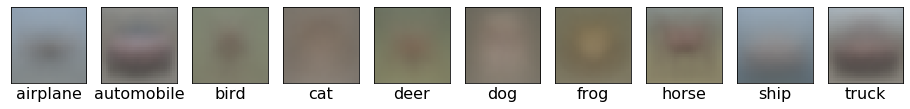

In [4]:
"""Visualise average images"""

avg_im=[]

# FORNOW: use first image of each class
for i in range(10):
    j = next(k for k in range(num_train) if Y_train[k]==i)
    avg_im.append(im_train[j])

"""
************************************************************
*** TODO: write code to compute average image for each class
************************************************************

Compute the average image for each class and store in avg_im
"""        

avg_im = []

for i in range(num_classes):
    avg_list = []
    for j in range(num_train):
        if Y_train[j] == i:
            avg_list.append(im_train[j])
    avg_arr = np.array(avg_list)
    mean_im = np.mean(avg_arr, axis=0)
    avg_im.append(mean_im)

"""
************************************************************
"""

for i in range(10):
    ax=plt.subplot(1,10,i+1)
    im_util.remove_ticks(ax)
    plt.xlabel(cifar10_names[i])
    plt.imshow(avg_im[i])

### Nearest Mean Classifier [5%]

In this part you'll use the average images computed above to construct a nearest mean classifier. Classify each element in the test set to the training set mean with smallest squared distance. Fill in the prediction vector for the test set `Y_hat`. You should get an accuracy of around 29%. 

Nearest mean classifier accuracy = 27.73%


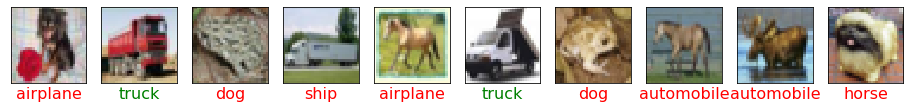

In [5]:
"""Nearest Mean Classifier"""

#FORNOW: random labels
Y_hat=np.random.randint(0,10,num_test)

"""
**********************************************
*** TODO: classify test data using mean images
**********************************************

Set the predictions Y_hat for the test set by finding the nearest mean image 
"""

for i in range(num_test):
    pred_dist, pred_label = float('inf'), -1
    for j in range(num_classes):
        dist = np.linalg.norm(im_test[i] - avg_im[j])
        if dist < pred_dist:
            pred_dist = dist
            pred_label = j
    Y_hat[i] = pred_label

"""
**********************************************
"""

nm_accuracy=np.sum(Y_hat==Y_test)/num_test
im_util.plot_classification_examples(Y_hat,Y_test,im_test,cifar10_names)

print('Nearest mean classifier accuracy = %.2f%%' % (100.0*nm_accuracy))

### Nearest Neighbour Classifier [5%]

Another simple classifier classifies each test item to the class of the nearest neighbour in the training set. Implement and test this below. Hint: you can use the `compute_distances` function from Project 1/2. Since computing nearest neighbours exactly is quite slow, we'll use a smaller version of the test set with only 1000 examples.

In [6]:
"""Nearest Neighbour Classifier"""

num_test_small=1000
X_test_small=X_test[0:num_test_small]
Y_test_small=Y_test[0:num_test_small]

#FORNOW: random labels
Y_hat=np.random.randint(0,10,num_test_small)


"""
*****************************************************
*** TODO: classify test data using nearest neighbours
*****************************************************

Set the predictions Y_hat for the test set using nearest neighbours from the training set
"""

def compute_distances(M1, M2):
    N1, num_dims = M1.shape
    N2, num_dims = M2.shape
    ATB = np.dot(M1, M2.T)
    AA = np.sum(M1 * M1, 1)
    BB = np.sum(M2 * M2, 1)
    return -2*ATB + np.expand_dims(AA, 1) + BB

dists = compute_distances(X_test_small, X_train)

for i in range(num_test_small):
    argmin = np.argmin(dists[i])
    Y_hat[i] = Y_train[argmin]
    

"""
*****************************************************
"""

nn_accuracy=np.sum(Y_hat==Y_test_small)/num_test_small
print('Nearest neighbour classifier accuracy =% .2f%%' % (100.0*nn_accuracy))

Nearest neighbour classifier accuracy = 34.60%


### Note on Improved Classifiers

There are several possible ways to improve the performance of the above classifiers. Some common approaches include extracting features from the input data, finding discriminatvie projections, or modifying the distance function used (e.g., Mahalanobis distance). In this assignment we'll skip straight ahead to linear regression, but if you have an idea you'd like to try out to improve the nearest neighbour or nearest mean classifiers, feel free to experiment in the space below. Note: there are no marks for this part, it is just for fun!

### Linear Classifier [5%]

We will now fit a simple linear classifier to the CIFAR10 training data. To do this, we'll need to convert class labels `Y` to one-hot target vectors `T`. Take a look at the `one_hot` function below and make sure you understand how it works. Then set up a linear system to minimize squared errors against the one-hot target vector, i.e., solve $W = \arg\min_W |XW-T|^2$. Hint: you can use `np.linalg.lstsq` to solve the least squares problem. You should get approximately 35% accuracy. Note: since the linear weights are the same shape as the data we can visualise them as an image. What do you notice?

#### A: The visualizations are a noisy matrix that's trying to overfit to the training data, leading to a seemly random set of intensities

Linear classifier accuracy = 35.85%


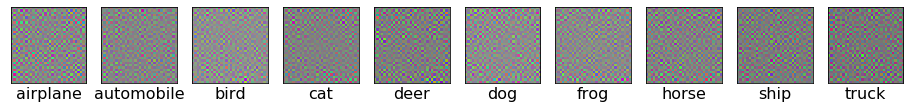

In [7]:
"""Linear Classifier"""

#FORNOW: random weight matrix for W 
W=np.random.randn(num_dims,num_classes)

def one_hot(Y, num_classes):
    """convert class labels to one-hot vector"""
    num_train=Y.size
    T = np.zeros((num_train, num_classes))
    T[np.arange(num_train), Y]=1
    return T

"""
*****************************************************
*** TODO: fit a linear classifier to the CIFAR10 data
*****************************************************

Set the weight vector W by solving a linear system with training data and targets
"""

Y_hot = one_hot(Y_train, num_classes)
W, _, _, _ = np.linalg.lstsq(X_train, Y_hot, rcond=None)

"""
*****************************************************
"""

# predict labels on the test set using W
T_hat = np.dot(X_test,W)
Y_hat = np.argmax(T_hat,1)

lin_accuracy=np.sum(Y_hat==Y_test)/num_test

print('Linear classifier accuracy =% .2f%%' % (100.0*lin_accuracy))

# visualise the linear weights
im_util.plot_weights(W, cifar10_names)

### Regularized Linear Classifier [10%]

The code above finds the linear weights that exactly minimize the squared error on the training set, with no prior over the weight settings. In this part, we will add a penalty for large weights, this is called regularisation. Modify your linear fitting code to include regularization with an L2 penalty on the weights, i.e., solve $W = \arg\min_W |XW - T|^2 + \lambda |W|^2$. Hint: set the derivative of this equation with respect to W to zero, and use `np.linalg.solve` to solve the linear system.

Linear classifier accuracy = 37.31%


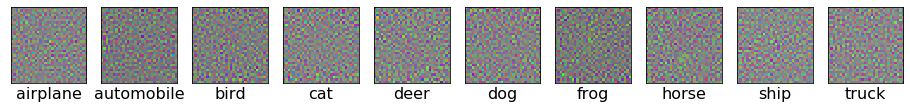

In [8]:
"""Regularised Linear Classifier"""

#FORNOW: random weight matrix for W 
W=np.random.randn(num_dims,num_classes)

lam=1 # regularization parameter lambda

"""
*****************************************************
*** TODO: add regularization to the linear classifier
*****************************************************

Add an L2 penalty to the weights using regularization parameter lam
"""

a = np.dot(X_train.T, X_train) + lam * np.eye(num_dims, num_dims)
b = np.dot(X_train.T, Y_hot)
W = np.linalg.solve(a, b)

"""
*****************************************************
"""

# compute accuracy on the test set

def linear_classify(X,W,Y):
  T_hat = np.dot(X,W)
  Y_hat = np.argmax(T_hat,1)
  accuracy = np.sum(Y_hat==Y)/np.size(Y)
  return Y_hat, accuracy

_,lin_acc=linear_classify(X_test,W,Y_test)

print('Linear classifier accuracy =% .2f%%' % (100.0*lin_acc))

# visualise the linear weights
im_util.plot_weights(W, cifar10_names)

### Tune the Regularization Parameter [5%]

Vary the value of the regularization parameter $\lambda=$`lam` and observe the weights and test error. What is happening? Use the validation set to tune the value of `lam` over a range and report results on the test set.

In [9]:
"""Tune the Regularization Parameter"""

"""
*************************************************************************************************
*** TODO: fine a good value of lambda using the validation set and report results on the test set
*************************************************************************************************
"""

lam_test_range = [0.01, 0.1, 1.0, 10.0, 100.0, 100.0, 10000.0, 100000.0]
best_acc = -1, 
best_lam = -1

for lam in lam_test_range:
  a = np.dot(X_train.T, X_train) + lam * np.eye(num_dims, num_dims)
  b = np.dot(X_train.T, Y_hot)
  W = np.linalg.solve(a, b)

  _,lin_acc=linear_classify(X_valid,W,Y_valid)
  if lin_acc > best_acc:
    best_acc = lin_acc
    best_lam = lam
    
print('Best validation accuracy = %.2f%% with lam = %.1f' % (100.0*best_acc, best_lam))


lam = best_lam
a = np.dot(X_train.T, X_train) + lam * np.eye(num_dims, num_dims)
b = np.dot(X_train.T, Y_hot)
W = np.linalg.solve(a, b)

_,lin_acc=linear_classify(X_test,W,Y_test)
print('Linear classifier test accuracy =% .2f%%' % (100.0*lin_acc))
    

"""
*************************************************************************************************
"""


Best validation accuracy = 40.60% with lam = 10000.0
Linear classifier test accuracy = 39.48%


'\n*************************************************************************************************\n'

### Stochastic Gradient Descent [10%]

The code above solved for the weights `W` by solving a single linear system over all the data. If the dataset is really large, or the parameter space is big, or the classifier is non-linear, this approach no longer works. In the following, we we solve the same problem using Stochastic Gradient Descent (SGD). This works by selecting a subset of data and taking a step in the direction of the gradient of the loss function $L(W)$. To start, work out the gradient of the loss with regularization used above, i.e., $\frac{dL}{dW}$. Then set up a loop where the weights are modified by $\alpha\frac{dL}{dW}$ where $\alpha$ is the learning rate. Note that the regularization parameter $\lambda$ is often called 'weight decay' in the context of SGD for reasons which should become clear. Experiment with the learning rate and make sure you can get the validation accuracy to increase. Note: SGD solver packages may not be used in your answer, but can optionally be used to compare your results.

 valid acc = 12.10%
 valid acc = 12.90%
 valid acc = 12.60%
 valid acc = 12.30%
 valid acc = 11.90%
 valid acc = 12.10%
 valid acc = 12.20%
 valid acc = 12.60%
 valid acc = 12.30%
 valid acc = 12.80%
 valid acc = 12.50%
 valid acc = 12.10%
 valid acc = 12.00%
 valid acc = 12.40%
 valid acc = 12.30%
 valid acc = 12.00%

test accuracy = 11.53%


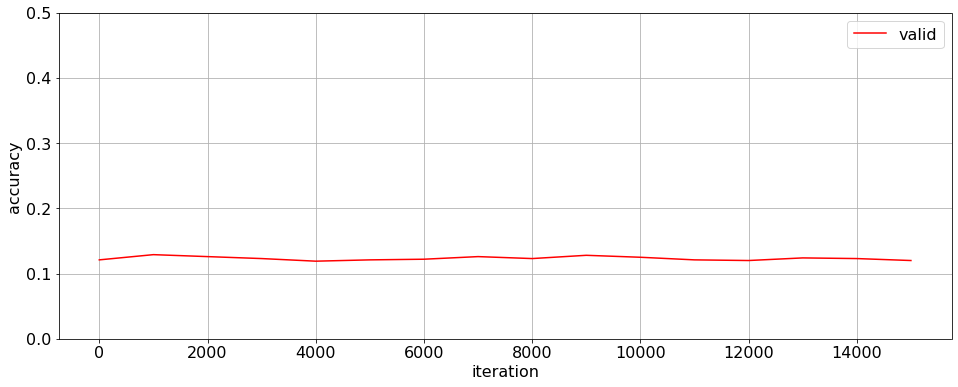

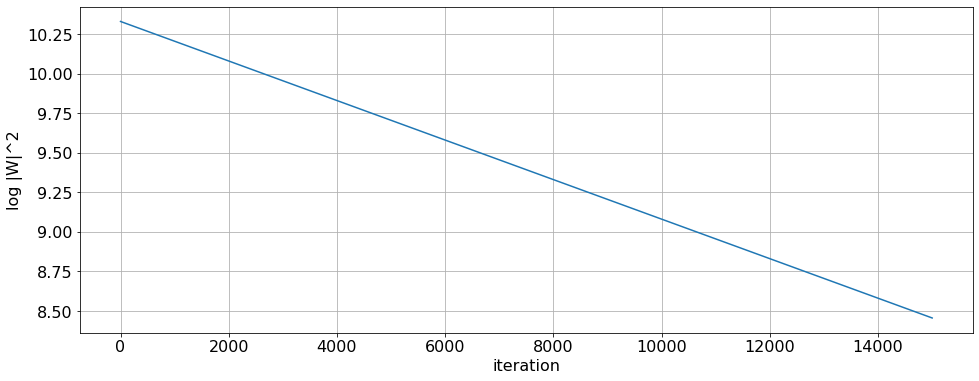

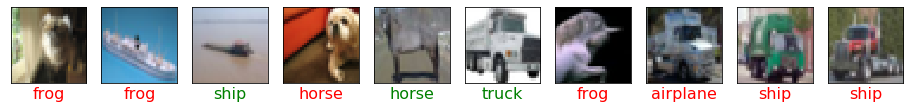

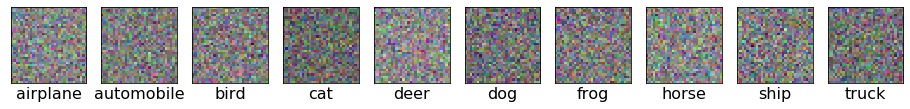

In [18]:
"""Linear Classifier by Stochastic Gradient Descent"""

batch_size=32
weight_decay=10000 # same as lambda
learning_rate=1e-7

num_epochs=10
num_iterations=num_epochs*(int)(num_train/batch_size)

np.random.seed(42)
W=np.random.randn(num_dims,num_classes)


valid_acc_seq=[]
iteration_seq=[]
W_seq=[]
W_sq_seq=[]

summary_interval=1000

for i in range(num_iterations):
    
    #FORNOW: random gradient
    grd = np.random.randn(num_dims,num_classes)
    dW = -grd
    """
    *************************************************************************************
    *** TODO: implement stochastic gradient descent for the regularized linear classifier
    *************************************************************************************

    Select a random batch of data and take a step in the direction of the gradient
    """

    batch_idx = np.random.choice(num_train, batch_size)
    X_batch = X_train[batch_idx]
    Y_batch = Y_train[batch_idx]
    Y_batch_hot = one_hot(Y_batch, num_classes)
    grd = 2 * np.dot(X_batch.T, (np.dot(X_batch, W) - Y_batch_hot)) + 2 * weight_decay * W
    dW = -learning_rate * grd / batch_size
    
    """
    *************************************************************************************
    """
    W = W + dW
    
    if (i % summary_interval == 0):
        _,valid_acc=linear_classify(X_valid,W,Y_valid)
        valid_acc_seq.append(valid_acc)
        iteration_seq.append(i)
        print(' valid acc =% .2f%%' % (100.0 * valid_acc))    
        W_seq.append(W)
        W_sq_seq.append(np.sum(W**2))

# plot validation accuracy and weight trends
plt.rcParams['figure.figsize'] = (16.0, 6.0)

fig=plt.figure()
plt.grid(True)
plt.plot(iteration_seq,valid_acc_seq,'r')
plt.xlabel('iteration')
plt.ylabel('accuracy')
plt.ylim(0,0.5)
plt.legend(['valid'])

fig=plt.figure()
plt.grid(True)
plt.plot(iteration_seq,np.log(W_sq_seq))
plt.xlabel('iteration')
plt.ylabel('log |W|^2')

# compute test accuracy
Y_hat,test_acc=linear_classify(X_test,W,Y_test)
print('\ntest accuracy = %.2f%%' % (100.0*test_acc))
im_util.plot_classification_examples(Y_hat,Y_test,im_test,cifar10_names)
im_util.plot_weights(W,cifar10_names)

### Investigate Stochastic Gradient Descent [15%]

Test your SGD solver with a range of parameter settings for batch size, learning rate and weight decay. Can you get similar performance to the least squares solver? Try out some improvements to your solver and document your findings here. Some areas for exploration could be: initialization of W, momentum solvers, softmax regression, or ideas of your own. Tune parameters on the validation set and report results on the test set.

In [11]:
"""Investigate Stochastic Gradient Descent"""

"""
*******************************************************
*** TODO: improve SGD solver and document your findings
*******************************************************
"""


"""
*******************************************************
"""

'\n*******************************************************\n'

**End of Part 1:** You are now ready to move on to [Part 2](https://courses.cs.washington.edu/courses/csep576/20sp/projects/Project3_2.html) of the project.